# Part 3 - Remote Sensing - AMLD 2019

data: https://drive.google.com/drive/folders/1N5qmLLyOt1tfLastLYv507drIs0sINCP?usp=sharing

In [79]:
import rasterio
from os import path as op
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [80]:
data_folder = '/Users/gmilani/workshop_amld'
list_feature_file = ['dem.tif', 'energy.tif', 'aspect.tif', 'slope.tif']
classification_file = 'classif_s2.tif'

output_s2_only = 'snow_s2_only.tiff'
output_s2_modis = 'output_s2_modis.tiff'
output_s2_modis_overwrite = 'output_s2_modis_overwrite.tiff'

# 1. Prediction based on single image

### Loading of features

In [81]:
with rasterio.open(op.join(data_folder, 'environment', list_feature_file[0])) as dataset:
    height = dataset.height
    width = dataset.width

data_stack = np.empty((height, width, len(list_feature_file)))

for index, feature_file in enumerate(list_feature_file):
    with rasterio.open(op.join(data_folder, 'environment', feature_file)) as dataset:
        data_stack[:,:,index] = dataset.read(1)
        
data_stack = data_stack.reshape((-1, len(list_feature_file)))

### Selection of training data

Among the labelled data, we select a sample of pixels labbeled as snow and another labbeled as snow-free. We also extract the mask of cloudy pixels

In [82]:
source_file = op.join(data_folder, 's2_17', classification_file) 
with rasterio.open(source_file) as dataset:
    classification = dataset.read(1).reshape((-1))

mask_free = np.logical_or(np.logical_and(classification > 3, classification < 7), classification == 14)
mask_snow = classification == 11
mask_cloud = np.logical_or(mask_free, mask_snow) == False

index_snow = np.where(mask_snow)[0]
selected_index_snow = np.random.choice(index_snow, size=1000)
index_free = np.where(mask_free)[0]
selected_index_free = np.random.choice(index_free, size=1000)

X = data_stack[np.append(selected_index_free, selected_index_snow), :]
y = ([0, ] * len(selected_index_free))
y.extend([1, ] * len(selected_index_snow))

In [83]:
classifier = RandomForestClassifier(10, min_samples_split=5, n_jobs=4)
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

We predict the label only for pixels labelled as cloud

In [84]:
prediction = classifier.predict(data_stack[mask_cloud, :])

Product generation and save to file

In [85]:
result = np.zeros(classification.shape, dtype = np.uint8)
result[mask_snow] = 1
result[mask_cloud] = prediction
result = result.reshape(height, width)

with rasterio.open(source_file) as dataset:
    profile = dataset.profile

with rasterio.open(op.join(data_folder, 'output', output_s2_only), 'w', **profile) as dataset:
    dataset.write(result, 1)

# Points of reflexion

* What are the errors in the classified map ?
* What are possible ways of improvement ?


# 2. Support by coarse-resolution Imagery

The idea now is to pre-train the random forest based on a coarse-resolution image taken 2 days before.

In [86]:
classification_file = 'classif_modis.tif'
with rasterio.open(op.join(data_folder, 'mod15', classification_file)) as dataset:
    classification = dataset.read(1).reshape((-1))

mask_free = np.logical_or(np.logical_and(classification > 3, classification < 7), classification == 14)
mask_snow = classification == 11
mask_cloud = np.logical_or(mask_free, mask_snow) == False

In [87]:
index_snow = np.where(mask_snow)[0]
selected_index_snow = np.random.choice(index_snow, size=1000)
index_free = np.where(mask_free)[0]
selected_index_free = np.random.choice(index_free, size=1000)

In [88]:
X = data_stack[np.append(selected_index_free, selected_index_snow), :]
y = ([0, ] * len(selected_index_free))
y.extend([1, ] * len(selected_index_snow))

In [89]:
classifier = RandomForestClassifier(10, min_samples_split=5, warm_start=True, n_jobs=4)
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

In [90]:
classification_file = 'classif_s2.tif'
source_file = op.join(data_folder, 's2_17', classification_file) 
with rasterio.open(source_file) as dataset:
    classification = dataset.read(1).reshape((-1))

mask_free = np.logical_or(np.logical_and(classification > 3, classification < 7), classification == 14)
mask_snow = classification == 11
mask_cloud = np.logical_or(mask_free, mask_snow) == False

index_snow = np.where(mask_snow)[0]
selected_index_snow = np.random.choice(index_snow, size=1000)
index_free = np.where(mask_free)[0]
selected_index_free = np.random.choice(index_free, size=1000)

X = data_stack[np.append(selected_index_free, selected_index_snow), :]
y = ([0, ] * len(selected_index_free))
y.extend([1, ] * len(selected_index_snow))


In [91]:
classifier.set_params(n_estimators=20)
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=4,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

In [92]:
prediction = classifier.predict(data_stack[mask_cloud, :])
result = np.zeros(classification.shape, dtype = np.uint8)
result[mask_snow] = 1
result[mask_cloud] = prediction
result = result.reshape(height, width)

with rasterio.open(source_file) as dataset:
    profile = dataset.profile

with rasterio.open(op.join(data_folder, 'output', output_s2_modis), 'w', **profile) as dataset:
    dataset.write(result, 1)

### Alternate product generation to overwrite the initial labels

In [93]:
prediction = classifier.predict(data_stack)

result = np.array(prediction, dtype = np.uint8)
result = result.reshape(height, width)

with rasterio.open(source_file) as dataset:
    profile = dataset.profile

with rasterio.open(op.join(data_folder, 'output', output_s2_modis_overwrite), 'w', **profile) as dataset:
    dataset.write(result, 1)

# Sample code to visualize TIFF raster in notebook

<IPython.core.display.Javascript object>


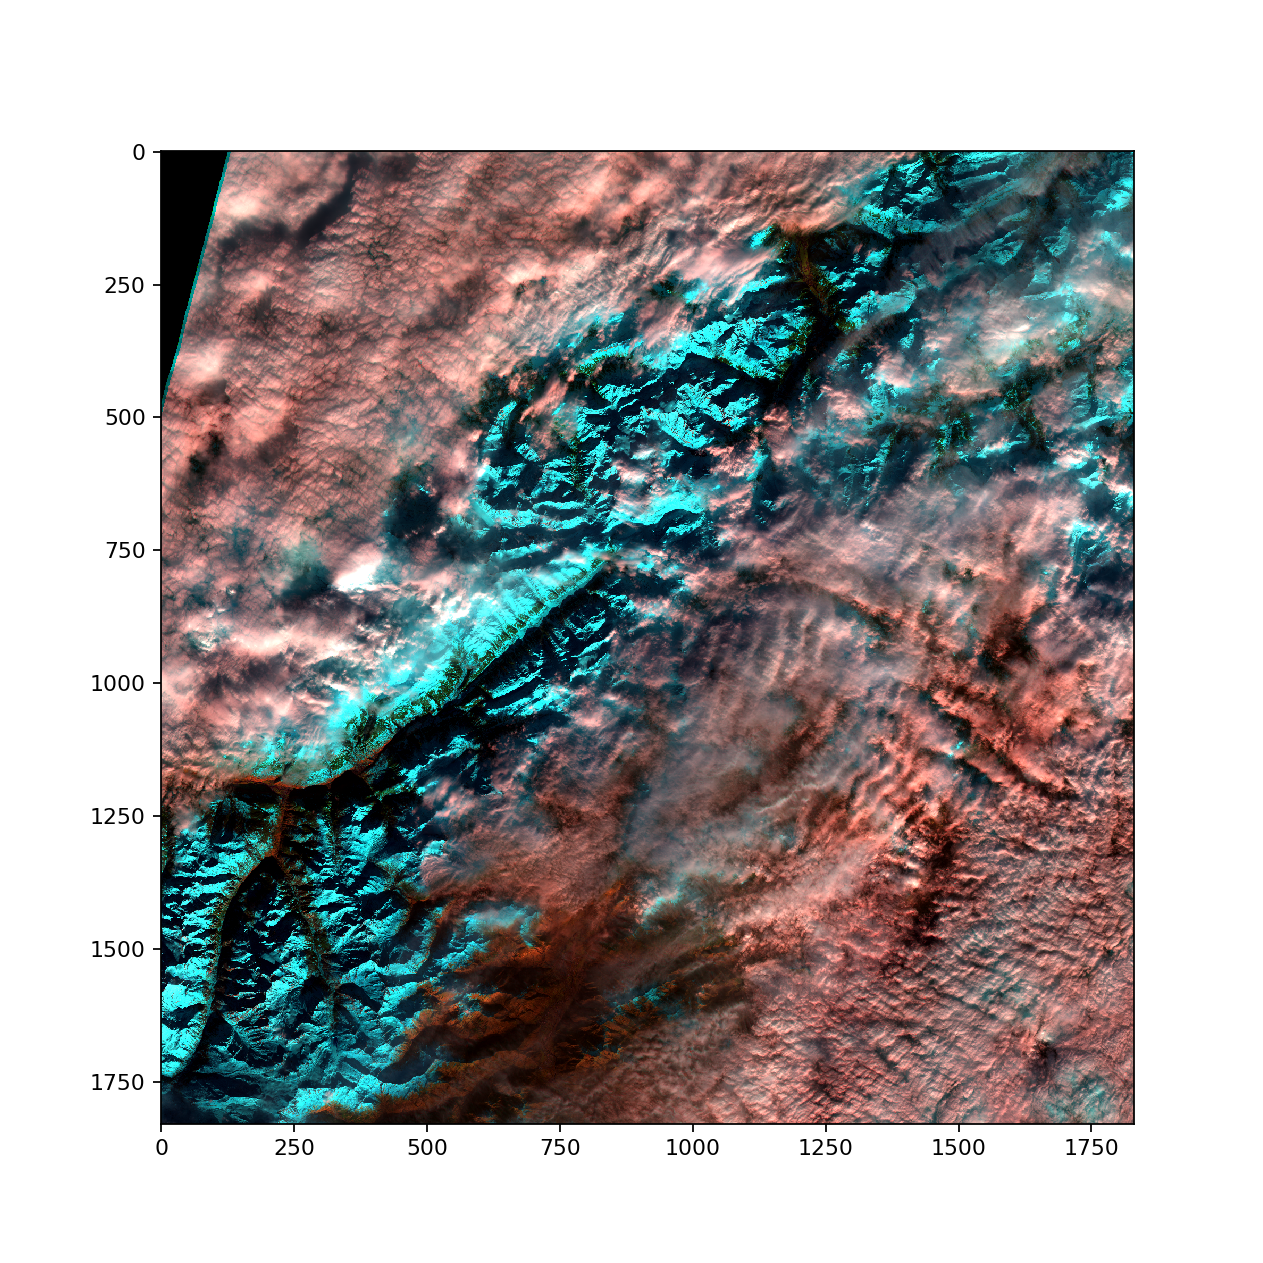

In [124]:
%matplotlib notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 8]

with rasterio.open(op.join(data_folder, 's2_17/s2_17.tif'), 'r') as dataset:
    image = dataset.read([11, 8, 3])
    
    for i, band in enumerate(image):
        array_min, array_max = np.percentile(band, 2), np.percentile(band, 98)
        band = ((band - array_min)/(array_max - array_min))
        band[band < 0] = 0
        band[band > 1] = 1
        image[i, :, :] = band * 255

from rasterio.plot import show
show(image)